# Baseline Linear Regression

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# two levels up from the notebook to project root, then append to sys.path
sys.path.append(str(Path().resolve().parents[1]))

PROJECT_ROOT = Path().resolve().parents[1]
RESULTS_PATH = PROJECT_ROOT / "results"


from utils.data_loading import load_datasets
from utils.data_preparation import get_spo2_to_po2_interpolator, add_shift_raw_column
from utils.evaluation import evaluate_macro_patient_level, print_evaluation, bland_altman_plots
from utils.modeling import fit_cv_models, predict_cv_ensemble
from utils.logging import log_run_json


train_df, test_df, val_df, odc = load_datasets()
spo2_to_po2 = get_spo2_to_po2_interpolator(odc)

train_df = add_shift_raw_column(train_df, spo2_to_po2)
test_df  = add_shift_raw_column(test_df, spo2_to_po2)
val_df   = add_shift_raw_column(val_df, spo2_to_po2)

In [3]:
from sklearn.linear_model import LinearRegression

In [4]:
features = ['PiO2(kPa)', 'SpO2(%)']

# Train ensemble of CV models
cv_models = fit_cv_models(
    train_df,
    features=features,
    target_col='shift',
    model_class=LinearRegression,
    k=10
)

# Predict on test set (average over CV models)
test_df['y_pred'] = predict_cv_ensemble(test_df, features, cv_models)

# Evaluate macro-averaged patient metrics
summary = evaluate_macro_patient_level(test_df, y_true_col='shift', y_pred_col='y_pred')
print_evaluation(summary)


Macro-averaged per-patient metrics:
MAE  = 1.049
MSE  = 2.769
RMSE = 1.256
Mean Bias Error = 0.010
MAPE = 9.853%
nRMSE = 6.678%


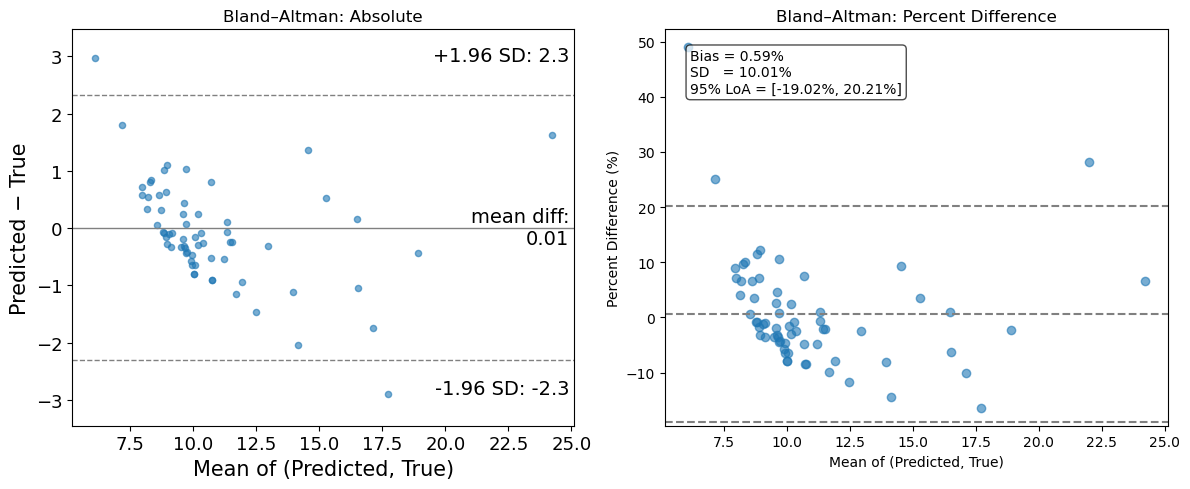

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'Bland–Altman: Absolute'}, xlabel='Mean of (Predicted, True)', ylabel='Predicted − True'>,
        <Axes: title={'center': 'Bland–Altman: Percent Difference'}, xlabel='Mean of (Predicted, True)', ylabel='Percent Difference (%)'>],
       dtype=object))

In [5]:
bland_altman_plots(test_df, y_true_col='shift', y_pred_col='y_pred', group_col='Anon.Patient_ID')


In [6]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression


def sample_n_per_patient(df, n, seed=42):
    np.random.seed(seed)
    return df.groupby('Anon.Patient_ID').apply(lambda x: x.sample(min(n, len(x)), random_state=seed)).reset_index(drop=True)

def run_sampling_experiment(train_df, test_df, feature_cols, target_col='shift', model_class=LinearRegression, k=10, max_points_per_patient_list=[1, 2, 3, 4, 5, None]):
    results = {}
    for n in max_points_per_patient_list:
        label = f'{n}_points' if n is not None else 'all_points'

        if n is not None:
            sampled_train_df = sample_n_per_patient(train_df, n=n)
        else:
            sampled_train_df = train_df.copy()

        # Train models using your existing CV ensemble function
        cv_models = fit_cv_models(sampled_train_df, features=feature_cols, target_col=target_col, model_class=model_class, k=k)
        
        # Predict on test set
        test_df['y_pred'] = predict_cv_ensemble(test_df, feature_cols, cv_models)

        # Evaluate on test set (macro average)
        summary = evaluate_macro_patient_level(test_df, y_true_col=target_col, y_pred_col='y_pred')

        print(f"\n=== Evaluation using {label} per patient ===")
        print_evaluation(summary)

        results[label] = summary
    
    return results


In [7]:
results = run_sampling_experiment(
    train_df=train_df,
    test_df=test_df,
    feature_cols=['PiO2(kPa)', 'SpO2(%)'],
    target_col='shift',
    model_class=LinearRegression,
    k=10,
    max_points_per_patient_list=[1, 2, 3, 4, 5, None]  # None means all available
)


/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_15546/2797966096.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('Anon.Patient_ID').apply(lambda x: x.sample(min(n, len(x)), random_state=seed)).reset_index(drop=True)
/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_15546/2797966096.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('Anon.Patient_I


=== Evaluation using 1_points per patient ===
Macro-averaged per-patient metrics:
MAE  = 1.090
MSE  = 3.153
RMSE = 1.310
Mean Bias Error = -0.052
MAPE = 10.087%
nRMSE = 6.963%

=== Evaluation using 2_points per patient ===
Macro-averaged per-patient metrics:
MAE  = 1.042
MSE  = 2.892
RMSE = 1.249
Mean Bias Error = 0.028
MAPE = 9.768%
nRMSE = 6.639%

=== Evaluation using 3_points per patient ===
Macro-averaged per-patient metrics:
MAE  = 1.051
MSE  = 2.938
RMSE = 1.258
Mean Bias Error = -0.007
MAPE = 9.803%
nRMSE = 6.688%

=== Evaluation using 4_points per patient ===
Macro-averaged per-patient metrics:
MAE  = 1.051
MSE  = 2.730
RMSE = 1.251
Mean Bias Error = -0.060
MAPE = 9.808%
nRMSE = 6.650%

=== Evaluation using 5_points per patient ===
Macro-averaged per-patient metrics:
MAE  = 1.045
MSE  = 2.722
RMSE = 1.246
Mean Bias Error = -0.025
MAPE = 9.792%
nRMSE = 6.624%

=== Evaluation using all_points per patient ===
Macro-averaged per-patient metrics:
MAE  = 1.049
MSE  = 2.769
RMSE = 1.

/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_15546/2797966096.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('Anon.Patient_ID').apply(lambda x: x.sample(min(n, len(x)), random_state=seed)).reset_index(drop=True)


In [8]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Sampling Strategy'})

results_df

,Sampling Strategy,MAE,MSE,RMSE,Mean Bias Error,MAPE,nRMSE,per_patient_MAE,per_patient_MSE,per_patient_RMSE,per_patient_Bias
0,1_points,1.090294,3.153209,1.309628,-0.051676,10.087126,6.963279,Anon.Patient_ID 6 1.193608 10 3.49475...,Anon.Patient_ID 6 2.064815 10 18.137...,Anon.Patient_ID 6 1.436946 10 4.25884...,Anon.Patient_ID 6 -0.303479 10 2.56496...
1,2_points,1.042065,2.892373,1.248646,0.028356,9.767969,6.63904,Anon.Patient_ID 6 0.996698 10 3.19420...,Anon.Patient_ID 6 1.508585 10 14.887...,Anon.Patient_ID 6 1.228245 10 3.85841...,Anon.Patient_ID 6 -0.220730 10 1.99812...
2,3_points,1.050758,2.938195,1.257911,-0.006897,9.803188,6.688302,Anon.Patient_ID 6 1.020301 10 3.24959...,Anon.Patient_ID 6 1.524178 10 15.469...,Anon.Patient_ID 6 1.234576 10 3.93316...,Anon.Patient_ID 6 -0.269607 10 2.08666...
3,4_points,1.050721,2.729834,1.25073,-0.059955,9.807727,6.650118,Anon.Patient_ID 6 1.066347 10 2.88183...,Anon.Patient_ID 6 1.700412 10 11.931...,Anon.Patient_ID 6 1.303998 10 3.45419...,Anon.Patient_ID 6 -0.236200 10 1.42060...
4,5_points,1.045233,2.722174,1.245856,-0.025444,9.792431,6.624203,Anon.Patient_ID 6 1.048371 10 2.88384...,Anon.Patient_ID 6 1.692804 10 11.951...,Anon.Patient_ID 6 1.301078 10 3.45708...,Anon.Patient_ID 6 -0.199037 10 1.43914...
5,all_points,1.049441,2.769191,1.256005,0.009765,9.852668,6.67817,Anon.Patient_ID 6 1.087892 10 2.95047...,Anon.Patient_ID 6 1.886091 10 12.573...,Anon.Patient_ID 6 1.373350 10 3.54587...,Anon.Patient_ID 6 -0.153734 10 1.62019...


In [ ]:
results_df_rounded = results_df.copy()
metrics_cols = ['Sampling Strategy', 'MAE', 'MSE', 'RMSE', 'Mean Bias Error', 'MAPE', 'nRMSE']

for col in metrics_cols:
    if col != 'Sampling Strategy':
        results_df_rounded[col] = pd.to_numeric(results_df_rounded[col], errors='coerce').round(3)
results_df_rounded[metrics_cols].to_csv(RESULTS_PATH / "sampling_experiment_metrics.csv", index=False)